## Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score #Кросс валидация

# Импорт оптимизаторов параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna

%matplotlib inline
plt.style.use('seaborn')

In [2]:
data = pd.read_csv('data/train_sem09.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


+ Первый столбец *Activity* содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
+ Остальные столбцы D1-D1776 представляют собой молекулярные **дескрипторы** — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.


## Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать **F1-score**.

Необходимо обучить две модели: **логистическую регрессию и случайный лес**. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать **все четыре метода** (*GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna*) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [3]:
X = data.drop(['Activity'], axis = 1)
y = data['Activity']

In [4]:
#Проверим по размерам выборок что разделение прошло успешно

print('Размер data', data.shape)
print('Размер X', X.shape)
print('Размер y', y.shape)

Размер data (3751, 1777)
Размер X (3751, 1776)
Размер y (3751,)


In [5]:
#Проверим, насколько равномерно разделены целевые данные
y.value_counts(normalize=True)

1    0.542255
0    0.457745
Name: Activity, dtype: float64

Данные разделены примерно одинаково, поэтому делать стратификацию не обязательно

In [6]:
#Разделим данные на тренировочные и тестовые

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

## **Создание BaseLine моделей**

Рассчитаем F1-score, на параметрах по умолчанию, для моделей логистической регрессии и случайном леса

In [7]:
#Baseline для логистической регрессии
logReg_base = linear_model.LogisticRegression(random_state=42, max_iter= 50)

logReg_base.fit(X_train, y_train)

y_pred_logReg_base = logReg_base.predict(X_test)

f1_logReg_base = metrics.f1_score(y_test, y_pred_logReg_base)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [8]:
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))

F1-score на Baseline для логистической регресии равен 0.79


In [9]:
#Baseline для случайного леса

rf_base = ensemble.RandomForestClassifier(random_state= 42)

rf_base.fit(X_train, y_train)

y_pred_rf_base = rf_base.predict(X_test)

f1_rf_base = metrics.f1_score(y_test, y_pred_rf_base)

In [10]:
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))

F1-score на Baseline для случайного леса равен 0.83


## **Построение модели с помощью GridSearchCV**

На основе логистической регресии

In [11]:
param_grid = [
    {'penalty' : ['l2', 'none'], # тип регуляризации
    'solver' : ['newton-cg', 'lbfgs', 'sag'], # алгоритм оптимизации
    'C' : [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
    
    #поскольку разные алгоритмы поддерживают разные типы регуляризации мы создадим еще 1 набор параметров
    {'penalty': ['l1', 'l2'] ,
    'solver': ['liblinear', 'saga'],
    'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

gs_logReg = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state= 42, max_iter = 50),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    scoring = 'f1'
)

%time gs_logReg.fit(X_train, y_train)

y_pred_gs_logReg = gs_logReg.predict(X_test)

f1_gs_logReg = metrics.f1_score(y_test, y_pred_gs_logReg)

CPU times: user 18.5 s, sys: 2.31 s, total: 20.8 s
Wall time: 25min 40s


In [12]:
print("Наилучшие значения гиперпараметров: {}".format(gs_logReg.best_params_))

Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


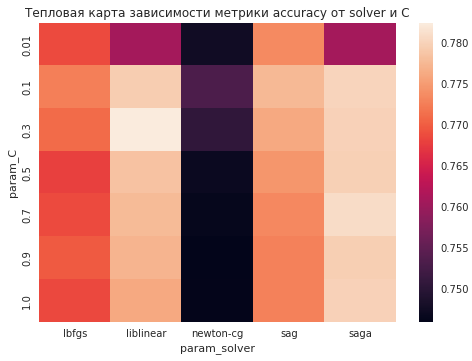

In [13]:
# посмотрим как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(gs_logReg.cv_results_),
                        values ='mean_test_score', index ='param_C',
                        columns ='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(15, 8)}) #задаем размер графика

Из тепловой карты видно, что нет смысла пробовать создать модель с большей силой регуляризации

In [14]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на GridSearchCV для логистической регресии равен {:.2f}'.format(f1_gs_logReg))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на GridSearchCV для логистической регресии равен 0.79


*К сожалению метрику улучшить не удалось*

На основе Случайного Леса

In [15]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': list(np.linspace(5, 25, 10, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 6, dtype=int))
              }
            
gs_rf = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state= 42),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    scoring = 'f1'
)

%time gs_rf.fit(X_train, y_train)

f1_gs_rf = gs_rf.score(X_test, y_test)

CPU times: user 17.6 s, sys: 1.34 s, total: 19 s
Wall time: 17min 59s


In [16]:
print("Наилучшие значения гиперпараметров: {}".format(gs_rf.best_params_))

Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 140}


In [17]:
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на GridResearchCV для случайного леса равен {:.2f}'.format(f1_gs_rf))

F1-score на Baseline для случайного леса равен 0.83
F1-score на GridResearchCV для случайного леса равен 0.84


*Метрика немного улучшилась*

## **RandomizedSearchCV**

Логистическая регрессия

In [18]:
param_distribution = [
    {'penalty' : ['l2', 'none'], # тип регуляризации
    'solver' : ['newton-cg', 'lbfgs', 'sag'], # алгоритм оптимизации
    'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
    
    #поскольку разные алгоритмы поддерживают разные типы регуляризации мы создадим еще 1 набор параметров
    {'penalty': ['l1', 'l2'] ,
    'solver': ['liblinear', 'saga'],
    'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]

rs_logReg = RandomizedSearchCV(
    estimator= linear_model.LogisticRegression(random_state=42, max_iter=50),
    param_distributions=param_distribution,
    cv = 5,
    n_iter = 50,
    n_jobs = -1,
    scoring = 'f1'
)

%time rs_logReg.fit(X_train, y_train)

f1_rs_logReg = rs_logReg.score(X_test, y_test)

CPU times: user 10.8 s, sys: 1.33 s, total: 12.1 s
Wall time: 19min 23s


In [19]:
print("Наилучшие значения гиперпараметров: {}".format(rs_logReg.best_params_))

Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.34}


In [20]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на RandomizedSrearchCV для логистической регресии равен {:.2f}'.format(f1_rs_logReg))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на RandomizedSrearchCV для логистической регресии равен 0.80


Случайный лес

In [21]:
param_distribution = {
    'min_samples_leaf' : list(np.linspace(5, 25, 10, dtype=int)),
    'max_depth' : list(np.linspace(1, 30, 6, dtype = int)),
    'n_estimators' : list(range(80, 200, 30))
}

rs_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_distribution,
    cv = 5,
    n_iter = 50,
    n_jobs = -1,
    scoring = 'f1'
)

%time rs_rf.fit(X_train, y_train)

f1_rs_rf = rs_rf.score(X_test, y_test)

CPU times: user 6.49 s, sys: 353 ms, total: 6.85 s
Wall time: 4min 6s


In [22]:
print("Наилучшие значения гиперпараметров: {}".format(rs_rf.best_params_))

Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 30}


In [23]:
#Сравним результат с BaseLine
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на RandomizedSrearchCV для случайного леса равен {:.2f}'.format(f1_rs_rf))

F1-score на Baseline для случайного леса равен 0.83
F1-score на RandomizedSrearchCV для случайного леса равен 0.84


## **HyperOpt**

Логистическая регрессия

In [24]:
# зададим пространство поиска гиперпараметров - получится 3 набора
# так как для каждого типа регуляции подходят только определённые алгоритмы оптимизации
space = {'penalty': hp.choice(label='penalty', options=['l2', 'none']) , # тип регуляризации
              'solver': hp.choice(label='solver', options=['lbfgs', 'sag', 'newton-cg']), # алгоритм оптимизации
              'C': hp.uniform('C', 0.01, 1)
              } # алгоритм оптимизации

# зафиксируем random_state
random_state = 42

def hyperopt(space, cv=5, X=X, y=y, random_state=random_state):
    """ Функция, обучающая модель LogisticRegression
    по переданным гиперпараметрам

    Args:
        space (dict): набор гиперпараметров
        cv (int, optional=5): Количество холдов кросс-валидации. Defaults to 5.
        X (DataFrame): DataFrame с признаками. Defaults to X_train.
        y (Series): Series с целевым признаком. Defaults to y_train.
        random_state (int): Рандомное число для воспроизводимости результата. Defaults to random_state.

    Returns:
        score(float): метрика F1
    """
    try:
        model = linear_model.LogisticRegression(
        penalty = space['penalty'],
        solver = space['solver'],
        C = np.abs(float(space['C'])),
        l1_ratio = float(space['l1_ratio']),
        random_state = random_state,
        max_iter = 50        
    )        
    except KeyError:
          
        model = linear_model.LogisticRegression(
        penalty = space['penalty'],
        solver = space['solver'],
        C = np.abs(float(space['C'])),
        random_state = random_state,
        max_iter = 50
           )
        
     
    # применим  cross validation 
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score



%time
              
trials = Trials() # используется для логирования результатов  

best = fmin(hyperopt, # наша функция 
          space = space, # пространство гиперпараметров
          algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals = 50, # максимальное количество итераций
          trials = trials, # логирование результатов
          rstate = np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print(f'Наилучшие значения гиперпараметров {best}')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
100%|██████████| 50/50 [21:55<00:00, 26.31s/it, best loss: -0.7918486627890561]
Наилучшие значения гиперпараметров {'C': 0.028607707583252345, 'penalty': 0, 'solver': 1}


In [25]:
from hyperopt import space_eval
hyperparams = space_eval(space, best)
hyperparams

{'C': 0.028607707583252345, 'penalty': 'l2', 'solver': 'sag'}

In [27]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state = random_state, 
    penalty = hyperparams['penalty'],
    solver = hyperparams['solver'],
    C = hyperparams['C']
)
model.fit(X_train, y_train)

y_pred_ho_lr = model.predict(X_test)

f1_ho_lr = metrics.f1_score(y_test, y_pred_ho_lr)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [28]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на HyperOpt для логистической регресии равен {:.2f}'.format(f1_ho_lr))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на HyperOpt для логистической регресии равен 0.80


Случайный лес

In [29]:
space={'n_estimators': hp.quniform('n_estimators', 80, 200, 1),
       'max_depth' : hp.quniform('max_depth', 1, 30, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 25, 1)
      }

In [30]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
    }
    # используем эту комбинацию для построения модели   
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return -score    

In [31]:
%time

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf, # наша функция 
          space = space, # пространство гиперпараметров
          algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals = 50, # максимальное количество итераций
          trials = trials, # логирование результатов
          rstate = np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: user 35 µs, sys: 0 ns, total: 35 µs
Wall time: 56 µs
100%|██████████| 50/50 [07:24<00:00,  8.88s/it, best loss: -0.8014811813337108]
Наилучшие значения гиперпараметров {'max_depth': 26.0, 'min_samples_leaf': 5.0, 'n_estimators': 143.0}


In [32]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state = random_state, 
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)

y_pred_ho_rf = model.predict(X_test)

f1_ho_rf = metrics.f1_score(y_test, y_pred_ho_rf)

In [33]:
#Сравним результат с BaseLine
print('F1-score на Baseline для случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на HyperOpt для случайного леса равен {:.2f}'.format(f1_ho_rf))

F1-score на Baseline для случайного леса равен 0.83
F1-score на HyperOpt для случайного леса равен 0.83


## **Optuna**

Логистическая регрессия

In [34]:
def optuna_lr(trial):
    penalty = trial.suggest_categorical(name='penalty', choices= ['l2', 'none']) # тип регуляризации
    solver = trial.suggest_categorical(name = 'solver', choices= ['newton-cg', 'lbfgs', 'sag']) # алгоритм оптимизации
    C = trial.suggest_float(name='C', low=0.01, high=1, step = 0.1) # уровень силы регурялизации
    
    model = linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C = C,
        random_state = random_state
    )
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    
    return score

In [35]:
%%time

study = optuna.create_study(study_name='LogisticRegression', direction='maximize')

study.optimize(optuna_lr, n_trials= 50)

[I 2022-11-16 09:13:55,998] A new study created in memory with name: LogisticRegression
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.01, 1] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.01, 0.91].
  low=low, old_high=old_high, high=high, step=step
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

CPU times: user 25min 1s, sys: 1min 43s, total: 26min 45s
Wall time: 51min 20s


In [36]:
model = linear_model.LogisticRegression(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)

y_pred_optuna_lr = model.predict(X_test)

f1_optuna_lr = metrics.f1_score(y_test, y_pred_optuna_lr)

In [37]:
#Сравним результат с BaseLine
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на Optuna для логистической регресии равен {:.2f}'.format(f1_optuna_lr))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на Optuna для логистической регресии равен 0.79


Случайный лес

In [38]:
def optuna_rf(trial):
    n_estimators =  trial.suggest_int('n_estimators', 80, 200, 1)
    max_depth = trial.suggest_int('max_depth', 1, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 25, 1)
    
    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state = random_state 
    )
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'f1', n_jobs= -1).mean()
    
    return score

In [39]:
%%time

study = optuna.create_study(study_name='RandomForestClassification', direction='maximize')

study.optimize(optuna_rf, n_trials= 50)

[I 2022-11-16 10:05:19,887] A new study created in memory with name: RandomForestClassification
[I 2022-11-16 10:05:25,988] Trial 0 finished with value: 0.7715536235447596 and parameters: {'n_estimators': 115, 'max_depth': 26, 'min_samples_leaf': 21}. Best is trial 0 with value: 0.7715536235447596.
[I 2022-11-16 10:05:28,173] Trial 1 finished with value: 0.7265528869608301 and parameters: {'n_estimators': 96, 'max_depth': 2, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.7715536235447596.
[I 2022-11-16 10:05:35,325] Trial 2 finished with value: 0.7726968938159083 and parameters: {'n_estimators': 157, 'max_depth': 18, 'min_samples_leaf': 23}. Best is trial 2 with value: 0.7726968938159083.
[I 2022-11-16 10:05:39,828] Trial 3 finished with value: 0.7763241768638831 and parameters: {'n_estimators': 88, 'max_depth': 17, 'min_samples_leaf': 18}. Best is trial 3 with value: 0.7763241768638831.
[I 2022-11-16 10:05:47,398] Trial 4 finished with value: 0.7814270048828271 and parameters:

CPU times: user 1min 56s, sys: 2.24 s, total: 1min 58s
Wall time: 7min 49s


In [40]:
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)

model.fit(X_train, y_train)

y_pred_optuna_rf = model.predict(X_test)

f1_optuna_rf = metrics.f1_score(y_test, y_pred_optuna_rf)

In [41]:
#Сравним результат с BaseLine
print('F1-score на Baseline для Случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на Optuna для Случайного леса равен {:.2f}'.format(f1_optuna_rf))

F1-score на Baseline для Случайного леса равен 0.83
F1-score на Optuna для Случайного леса равен 0.84


In [45]:
optuna.visualization.plot_optimization_history(study, target_name="F1-score")

## **Итоги**

Линейная регрессия

In [42]:
print('F1-score на Baseline для логистической регресии равен {:.2f}'.format(f1_logReg_base))
print('F1-score на GridSearchCV для логистической регресии равен {:.2f}'.format(f1_gs_logReg))
print('F1-score на RandomizedSrearchCV для логистической регресии равен {:.2f}'.format(f1_rs_logReg))
print('F1-score на HyperOpt для логистической регресии равен {:.2f}'.format(f1_ho_lr))
print('F1-score на Optuna для логистической регресии равен {:.2f}'.format(f1_optuna_lr))

F1-score на Baseline для логистической регресии равен 0.79
F1-score на GridSearchCV для логистической регресии равен 0.79
F1-score на RandomizedSrearchCV для логистической регресии равен 0.80
F1-score на HyperOpt для логистической регресии равен 0.80
F1-score на Optuna для логистической регресии равен 0.79


Случайный лес

In [43]:
print('F1-score на Baseline для Случайного леса равен {:.2f}'.format(f1_rf_base))
print('F1-score на GridResearchCV для случайного леса равен {:.2f}'.format(f1_gs_rf))
print('F1-score на RandomizedSrearchCV для случайного леса равен {:.2f}'.format(f1_rs_rf))
print('F1-score на HyperOpt для случайного леса равен {:.2f}'.format(f1_ho_rf))
print('F1-score на Optuna для Случайного леса равен {:.2f}'.format(f1_optuna_rf))

F1-score на Baseline для Случайного леса равен 0.83
F1-score на GridResearchCV для случайного леса равен 0.84
F1-score на RandomizedSrearchCV для случайного леса равен 0.84
F1-score на HyperOpt для случайного леса равен 0.83
F1-score на Optuna для Случайного леса равен 0.84
